---
title: 7.1 序列模型
date: 2024-4-30 14:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---
#  
<!--more-->
- 到目前为止我们默认数据都来自于某种分布，并且所有样本都是独立同分布的。然而，大多数的数据并非如此。例如，文章中的单词是按顺序写的，如果顺序被随机地重排，就很难理解文章原始的意思。
- 我们不仅仅可以接收一个序列作为输入，而是还可能期望继续猜测这个序列的后续。
- 如果说卷积神经网络可以有效地处理空间信息，那么循环神经网络（recurrent neural network，RNN）则可以更好地处理序列信息。循环神经网络通过引入状态变量存储过去的信息和当前的输入，从而可以确定当前的输出。
# 1 序列模型
## 1.1 统计工具
- 以股票价格（富时100指数）为例。
![](../../../../../../themes/yilia/source/img/deeplearning/code/pytorch/7_rnn/1_seqmodel/1.png)
![](img/deeplearning/code/pytorch/7_rnn/1_seqmodel/1.png)
    - 在时间步t观察到的价格为$x_ t$。t对于本文中的序列通常是离散的，并在整数或其子集上变化。假设一个交易员想在t日的股市中表现良好，于是通过以下途径预测xt：
    $$x_ t ∼ P(x_ t | x_ {t−1}, . . . , x_ 1)$$
### 1.1.1 自回归模型
- 输入数据的数量将会随着我们遇到的数据量的增加而增加，因此需要一个近似方法来使这个计算变得容易处理。如何有效估计P(xt | xt−1, . . . , x1),归结为以下两种策略。

    1. 假设在现实情况下相当长的序列 xt−1, . . . , x1可能是不必要的，因此我们只需要满足某个长度为$\tau$的时间跨度。这种模型被称为自回归模型（autoregressive models），因为它们是对自己执行回归。

    2. 如下图是保留一些对过去观测的总结$h_ t$，并且同时更新预测$\hat x_ t$的模型和总结$h_ t$。即：基于$\hat x_ t = P(x_ t | h_ t)$估计$x_ t$， 并使用$h_ t = g(x_ {t−1}, h_ {t−1})$来更新模型。由于$h _t$从未被观测到，这类模型也被称为 隐变量自回归模型（latent autoregressive models）。

    ![](../../../../../../themes/yilia/source/img/deeplearning/code/pytorch/7_rnn/1_seqmodel/2.png)
    ![](img/deeplearning/code/pytorch/7_rnn/1_seqmodel/2.png)

- 这两种情况都有一个显而易见的问题：如何生成训练数据？可以使用历史观测来预测下一个未来观测。整个序列的估计值都将通过以下的方式获得：
$$P(x_ 1, . . . , x_ T) = \prod _{t=1} ^T P(x_ t | x_ {t−1}, . . . , x_ 1)$$
### 1.1.2 马尔可夫模型
- 在自回归模型的近似法中，我们使用$x_ {t-1},\cdots,x_ {t - \tau}$而不是$x_ {t-1},\cdots,x_ 1$来估计$x_ t$。我们称这个模型为马尔可夫模型。如果$\tau = 1$，那么这个模型就是一阶马尔可夫模型：
    $$P(x_ 1, . . . , x_ T) = \prod _{t=1} ^T P(x_ t | x_ {t−1})$$

    $$P(x_ 1 | x_ 0) = P(x_ 1)$$

- 假设$x_ t$仅是离散值，使用动态规划可以沿着马尔可夫链精确地计算结果。例如，我们可以高效地计算$P(x_ {t+1} | X_ {t-1})$:
$$\begin{aligned} P(x_ { t + 1 } | x_ { t - 1 }) &= \frac { \sum _{ x_ t } P( x_ { t + 1 }, x_ t, x_ { t - 1 }) } { \sum _{ x_ t, x_ { t - 1 } } P( x_ { t + 1 }, x_ t, x_ { t - 1 }) } \\ &= \frac { \sum _{ x_ t } P( x_ { t + 1 } | x_ t, x_ { t - 1 }) P( x_ t | x_ { t - 1 }) P( x_ { t - 1 }) } { \sum _{ x_ t } P( x_ { t + 1 } | x_ t, x_ { t - 1 }) P( x_ t | x_ { t - 1 }) P( x_ { t - 1 }) } \\ &= \sum _{ x_ t } P( x_ { t + 1 } | x_ t ) P( x_ t | x_ { t - 1 }) \end{aligned}$$
- 对$x_ t$求和结果为1，相当于求和符号与$x_ t$可以消掉。

### 1.1.3 因果关系
- 通常，可以将$P(x_ 1, \cdots, x_ T)$倒序展开：
$$P(x_ 1, \cdots, x_ T) = \prod _{t=T} ^1 P(x_ t | x_ {t+1}, \cdots, x_ T)$$
- 如果基于一个马尔可夫模型，我们还可以得到一个反向的条件概率分布。但通常数据存在一个自然的方向，即在时间上是前进的。

## 1.2 训练
- 使用正弦函数和一些可加性噪声来生成序列数据，时间步为1, 2, . . . , 1000。

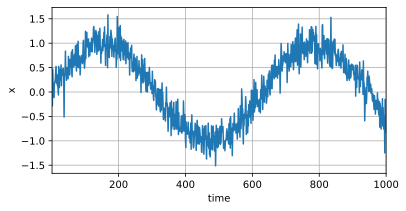

In [19]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
from torch import nn
from d2l import torch as d2l

T = 1000 #产生1000个点
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,)) #加入噪声
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

![](img/deeplearning/code/pytorch/7_rnn/1_seqmodel_files/1_seqmodel_1_0.svg)

- 将这个序列转换为模型的特征－标签（feature‐label）对。将数据映射为数据对$y_ t = x_ t$和 \mathbf{ x }_ t = [x_ { t - \tau }, \cdots, x_ { t - 1 }]$。这比我们提供的数据样本少了$\tau$个，在这里，我们仅使用前600个“特征－标签”对进行训练。

In [20]:
tau = 4
features = torch.zeros((T - tau, tau)) #[996, 4]
for i in range(tau):
    features[:, i] = x[i:T - tau+i] #[996]
labels = x[tau:].reshape((-1, 1)) #[996, 1]
'''
[x0, x1, x2, x3] -> [x4]
[x1, x2, x3, x4] -> [x5]
...
'''

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

- 构建一个简单的模型：
    - 两个全连接层的多层感知机，ReLU激活函数和平方损失。

In [21]:
# 初始化权重
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# mlp
def get_net():
    net = nn.Sequential(nn.Linear(4,10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

- 训练

In [22]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch+1},'
              f'loss:{d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1,loss:0.093809
epoch 2,loss:0.058604
epoch 3,loss:0.052532
epoch 4,loss:0.058827
epoch 5,loss:0.049325


## 1.3 预测
- 可以看到训练损失很小，因此我们期望模型能有很好的工作效果。单步预测：

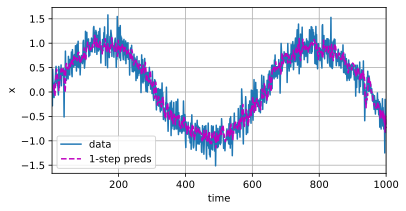

In [23]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
    'x', legend=['data', '1-step preds'], xlim=[1, 1000],
                 figsize=(6, 3)
        )

![](img/deeplearning/code/pytorch/7_rnn/1_seqmodel_files/1_seqmodel_9_0.svg)

- 对于直到$x_ t$的观测序列，其在时间步t + k处的预测输出$\hat x_ {t+k}$称为k步预测。
- 由于我们的观察已经到了x604，我们必须使用我们自己的预测（而不是原始数据）来进行多步预测。

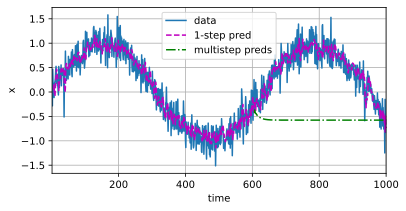

In [24]:
multistep_ppreds = torch.zeros(T)
multistep_ppreds[:n_train+ tau] = x[:n_train+ tau]
for i in range(n_train+ tau, T):
    multistep_ppreds[i] = net(multistep_ppreds[i- tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_ppreds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step pred', 'multistep preds'],
         xlim=[1, 1000], figsize=(6,3))

![](img/deeplearning/code/pytorch/7_rnn/1_seqmodel_files/1_seqmodel_11_0.svg)

- 绿线的预测显然并不理想。经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。为什么这个算法效果这么差呢？事实是由于错误的累积
- 基于k = 1, 4, 16, 64，通过对整个序列预测的计算，让我们更仔细地看一下k步预测的困难。


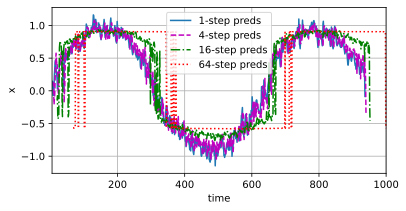

In [25]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau+max_steps)) #
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）\
'''
x0 x1 x2 x3
x1 x2 x3 x4
'''
for i in range(tau):
    features[:, i] = x[i: i+T-tau-max_steps+1]
# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
'''
x4 x5 x6 ... x67
x5 x6 x7 ... x68
'''
for i in range(tau, tau+max_steps):
    features[:, i] = net(features[:, i-tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
        [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
        legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
        figsize=(6, 3))

![](img/deeplearning/code/pytorch/7_rnn/1_seqmodel_files/1_seqmodel_13_0.svg)